In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../")
from src.core.timeseries_evaluation import get_quantile_scores, get_crps_scores, get_empirical_coverage_rates, get_crps_by_period, plot_crps, load_predictions, plot_crps_across_lead_times
from src.postprocessors.qr import PostprocessorQR
from src.postprocessors.mle import PostprocessorMLE
from src.pipeline.pipeline import ForecastingPipeline
from src.predictors.chronos import Chronos
import numpy as np
import pandas as pd
from pathlib import Path
from src.data.preprocessor import read_smard_data, read_exchange_rates_data

/Users/louisskowronek/Documents/thesis/master-thesis/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-27 18:31:44,989 - INFO - config.py - PyTorch version 2.5.1 available.


# Comparison of Transformation Methods for Quantile Regression Postprocessing

In [11]:
lead_times = np.arange(1, 64*3+1).tolist()
quantiles =np.arange(0.1,1,0.1).round(1).tolist()

In [6]:
# energy consumption

In [28]:
data, mapping, freq = read_smard_data(file_paths=["../data/Realisierter_Stromverbrauch_201501010000_202101010000_Stunde.csv",
                                                  "../data/Realisierter_Stromverbrauch_202101010000_202504240000_Stunde.csv"],
                                    selected_time_series=["Netzlast [MWh] Berechnete Auflösungen", 
                                                          "Residuallast [MWh] Berechnete Auflösungen"])

2025-05-26 18:42:40,160 - INFO - preprocessor.py - Reading SMARD data...
2025-05-26 18:42:40,161 - INFO - preprocessor.py - Reading file: ../data/Realisierter_Stromverbrauch_201501010000_202101010000_Stunde.csv
2025-05-26 18:42:40,336 - INFO - preprocessor.py - Reading file: ../data/Realisierter_Stromverbrauch_202101010000_202504240000_Stunde.csv
2025-05-26 18:42:40,447 - INFO - preprocessor.py - Total rows after concat: 90383
2025-05-26 18:42:40,448 - INFO - preprocessor.py - Filtering columns: ['Netzlast [MWh] Berechnete Auflösungen', 'Residuallast [MWh] Berechnete Auflösungen']
2025-05-26 18:42:40,448 - INFO - preprocessor.py - Columns retained: ['Datum von', 'Netzlast [MWh] Berechnete Auflösungen', 'Residuallast [MWh] Berechnete Auflösungen']
2025-05-26 18:42:40,455 - INFO - preprocessor.py - Reshaped DataFrame: 180746 rows
2025-05-26 18:42:40,464 - INFO - preprocessor.py - Mapped 2 unique time series.
2025-05-26 18:42:40,465 - INFO - preprocessor.py - Final DataFrame memory usage:

In [ ]:
# chronos zero shot results
pipeline = ForecastingPipeline(model=Chronos, 
                               model_kwargs={"pretrained_model_name_or_path": "amazon/chronos-bolt-tiny", "device_map": "mps", "lead_times": lead_times, "freq": freq}, 
                               postprocessors=[PostprocessorQR, PostprocessorQR, PostprocessorQR],
                               postprocessor_kwargs=[{"transformer": "yeo-johnson", "name": "PostprocessorQR_yj"}, 
                                                     {"transformer": "arcsinh", "name": "PostprocessorQR_arcsinh"},
                                                     {"transformer": None, "name": "PostprocessorQR_none"}],
                               output_dir=Path("../results/tests/transformations-QR/energy-consumption/chronos-zero-shot"))

results2 = pipeline.backtest(data=data,
                            test_start_date=pd.Timestamp("01-01-2023"),
                            rolling_window_eval=False,
                            train=False,
                            val_window_size=None,
                            train_window_size=None,
                            test_window_size=None,
                            calibration_based_on="train",
                            save_results=True)

2025-05-26 16:26:41,880 - INFO - chronos.py - Loading Chronos pipeline from model: amazon/chronos-bolt-tiny
2025-05-26 16:26:41,881 - INFO - chronos.py - Initializing Chronos pipeline with model: amazon/chronos-bolt-tiny
2025-05-26 16:26:42,755 - INFO - pipeline.py - Start E2E backtesting...
2025-05-26 16:26:42,756 - INFO - pipeline.py - Starting data split operation.
2025-05-26 16:26:42,761 - INFO - pipeline.py - Data split operation completed successfully.
2025-05-26 16:26:42,761 - INFO - pipeline.py - evaluate is set to true. Removing all item_ids which contain only nans in target column.
2025-05-26 16:26:42,763 - INFO - pipeline.py - Skipping model training because `train=False`.
2025-05-26 16:26:42,767 - INFO - pipeline.py - Starting prediction for test data from 2023-01-01 00:00:00 to 2025-04-23 23:00:00
2025-05-26 16:26:42,767 - INFO - pipeline.py - Running prediction using the model: Chronos
Predicting using Chronos:   0%|          | 0/2788 [00:00<?, ?it/s]/Users/louisskowronek

Exception ignored in: <function ResourceTracker.__del__ at 0x1073e5c60>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x102f25c60>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/

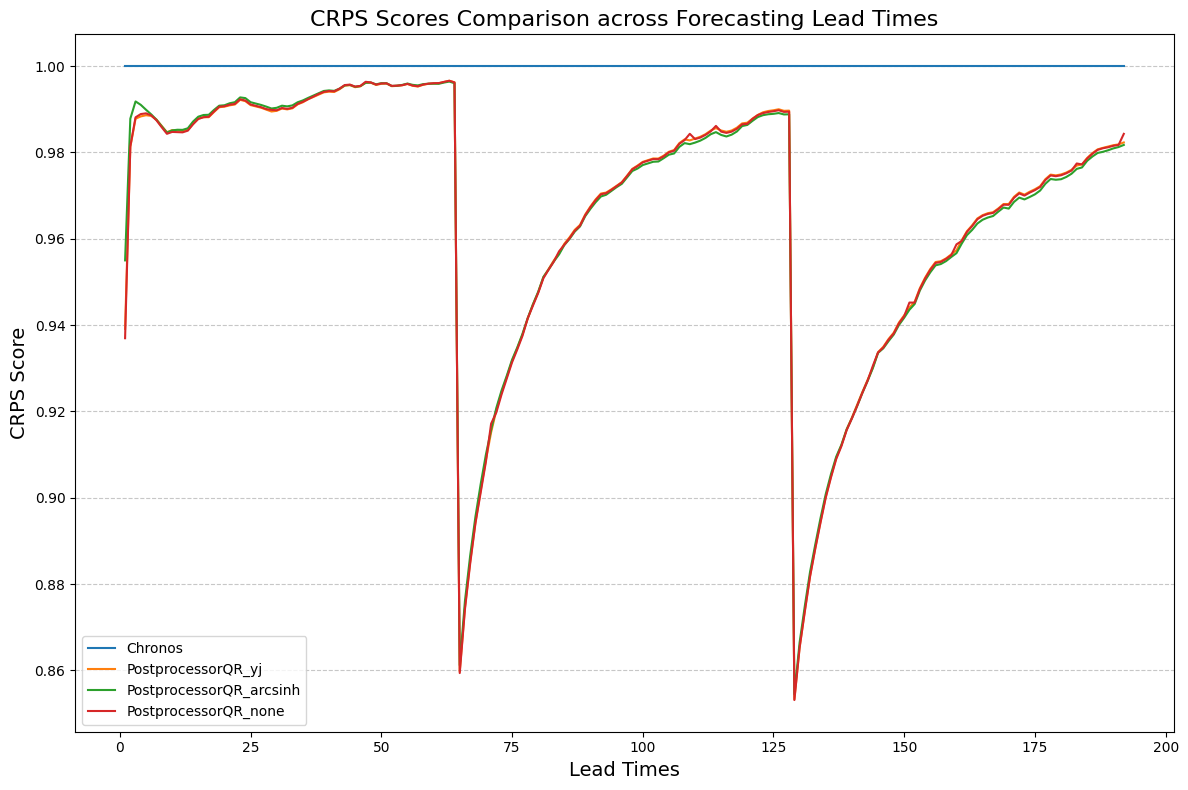

In [ ]:
plot_crps_across_lead_times(results2[0], reference_predictions="Chronos")

In [ ]:
get_crps_scores(results2[0])

,PostprocessorQR_arcsinh,PostprocessorQR_none,PostprocessorQR_yj,Chronos
lead times,,,,
1,872.305122,855.837113,857.815120,913.422442
2,1304.665846,1296.162580,1296.021016,1320.767846
3,1673.948905,1667.730710,1667.178056,1687.787707
4,1983.628156,1979.353642,1978.262894,2001.624001
5,2237.557064,2235.671524,2234.689130,2260.442329
...,...,...,...,...
189,4708.386204,4711.757234,4712.543762,4802.079494
190,4718.018351,4720.898925,4721.547577,4809.761421
191,4728.270058,4730.595944,4731.226199,4818.687021


In [ ]:
# execution time in seconds
results2[1]

{'postprocessors': {'postprocessors_execution_time': {'PostprocessorQR_yj': 249.94,
   'PostprocessorQR_arcsinh': 264.84,
   'PostprocessorQR_none': 543.06}}}

In [7]:
# exchange rates

In [9]:
data, mapping, freq = read_exchange_rates_data(files_dir="../data/exchange_rates/")

2025-05-26 17:31:09,621 - INFO - preprocessor.py - Reading exchange rates data...
2025-05-26 17:31:09,622 - INFO - preprocessor.py - Reading file: ../data/exchange_rates/DEXCAUS.csv
2025-05-26 17:31:09,631 - INFO - preprocessor.py - Reading file: ../data/exchange_rates/DEXCHUS.csv
2025-05-26 17:31:09,637 - INFO - preprocessor.py - Reading file: ../data/exchange_rates/DEXJPUS.csv
2025-05-26 17:31:09,644 - INFO - preprocessor.py - Reading file: ../data/exchange_rates/DEXSIUS.csv
2025-05-26 17:31:09,653 - INFO - preprocessor.py - Reading file: ../data/exchange_rates/DEXSZUS.csv
2025-05-26 17:31:09,662 - INFO - preprocessor.py - Reading file: ../data/exchange_rates/DEXUSAL.csv
2025-05-26 17:31:09,669 - INFO - preprocessor.py - Reading file: ../data/exchange_rates/DEXUSNZ.csv
2025-05-26 17:31:09,676 - INFO - preprocessor.py - Reading file: ../data/exchange_rates/DEXUSUK.csv
2025-05-26 17:31:09,683 - INFO - preprocessor.py - Total rows after concatenation: 9214
2025-05-26 17:31:09,687 - INFO

In [ ]:
# chronos zero shot results
pipeline = ForecastingPipeline(model=Chronos, 
                               model_kwargs={"pretrained_model_name_or_path": "amazon/chronos-bolt-tiny", "device_map": "mps", "lead_times": lead_times, "freq": freq}, 
                               postprocessors=[PostprocessorQR, PostprocessorQR, PostprocessorQR],
                               postprocessor_kwargs=[{"transformer": "yeo-johnson", "name": "PostprocessorQR_yj"}, 
                                                     {"transformer": "arcsinh", "name": "PostprocessorQR_arcsinh"},
                                                     {"transformer": None, "name": "PostprocessorQR_none"}],
                               output_dir=Path("../results/tests/transformations-QR/exchange-rates/chronos-zero-shot"))

results2 = pipeline.backtest(data=data,
                            test_start_date=pd.Timestamp("01-01-2023"),
                            rolling_window_eval=False,
                            train=False,
                            val_window_size=None,
                            train_window_size=None,
                            test_window_size=None,
                            calibration_based_on="train",
                            save_results=True)

2025-05-26 17:32:55,064 - INFO - chronos.py - Loading Chronos pipeline from model: amazon/chronos-bolt-tiny
2025-05-26 17:32:55,065 - INFO - chronos.py - Initializing Chronos pipeline with model: amazon/chronos-bolt-tiny
2025-05-26 17:32:55,936 - INFO - pipeline.py - Start E2E backtesting...
2025-05-26 17:32:55,937 - INFO - pipeline.py - Starting data split operation.
2025-05-26 17:32:55,939 - INFO - pipeline.py - Data split operation completed successfully.
2025-05-26 17:32:55,939 - INFO - pipeline.py - evaluate is set to true. Removing all item_ids which contain only nans in target column.
2025-05-26 17:32:55,941 - INFO - pipeline.py - Skipping model training because `train=False`.
2025-05-26 17:32:55,943 - INFO - pipeline.py - Starting prediction for test data from 2023-01-02 00:00:00 to 2025-04-25 00:00:00
2025-05-26 17:32:55,943 - INFO - pipeline.py - Running prediction using the model: Chronos
Predicting using Chronos:   0%|          | 0/1327 [00:00<?, ?it/s]/Users/louisskowronek

Exception ignored in: <function ResourceTracker.__del__ at 0x110e1dc60>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x107719c60>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/

In [13]:
get_crps_scores(results2[0])

,Chronos,PostprocessorQR_arcsinh,PostprocessorQR_yj,PostprocessorQR_none
lead times,,,,
1,0.002218,0.002263,0.002263,0.002262
2,0.002879,0.002919,0.002919,0.002919
3,0.003385,0.003426,0.003425,0.003426
4,0.003817,0.003859,0.003859,0.003860
5,0.004252,0.004294,0.004294,0.004293
...,...,...,...,...
189,0.015412,0.017603,0.017633,0.017809
190,0.015505,0.017684,0.017717,0.017860
191,0.015540,0.017742,0.017784,0.017930


In [14]:
results2[1]

{'postprocessors': {'postprocessors_execution_time': {'PostprocessorQR_yj': 121.62,
   'PostprocessorQR_arcsinh': 100.79,
   'PostprocessorQR_none': 100.0}}}

In [ ]:
# grosshandelspreise 

In [16]:
data, mapping, freq = read_smard_data(file_paths=["../data/Gro_handelspreise_201501010000_202101010000_Stunde.csv",
                                                  "../data/Gro_handelspreise_202101010000_202504240000_Stunde.csv"],
                                      selected_time_series=None)

2025-05-26 17:56:40,948 - INFO - preprocessor.py - Reading SMARD data...
2025-05-26 17:56:40,949 - INFO - preprocessor.py - Reading file: ../data/Gro_handelspreise_201501010000_202101010000_Stunde.csv
2025-05-26 17:56:41,118 - INFO - preprocessor.py - Reading file: ../data/Gro_handelspreise_202101010000_202504240000_Stunde.csv
2025-05-26 17:56:41,233 - INFO - preprocessor.py - Total rows after concat: 90383
2025-05-26 17:56:41,265 - INFO - preprocessor.py - Reshaped DataFrame: 1536341 rows
2025-05-26 17:56:41,333 - INFO - preprocessor.py - Mapped 17 unique time series.
2025-05-26 17:56:41,334 - INFO - preprocessor.py - Final DataFrame memory usage: 35.16 MB


In [ ]:
data = data.loc[0:4].copy() # only consider a subset of data for testing

In [22]:
# chronos zero shot results
pipeline = ForecastingPipeline(model=Chronos, 
                               model_kwargs={"pretrained_model_name_or_path": "amazon/chronos-bolt-tiny", "device_map": "mps", "lead_times": lead_times, "freq": freq}, 
                               postprocessors=[PostprocessorQR, PostprocessorQR, PostprocessorQR],
                               postprocessor_kwargs=[{"transformer": "yeo-johnson", "name": "PostprocessorQR_yj"}, 
                                                     {"transformer": "arcsinh", "name": "PostprocessorQR_arcsinh"},
                                                     {"transformer": None, "name": "PostprocessorQR_none"}],
                               output_dir=Path("../results/tests/transformations-QR/wholesale-prices/chronos-zero-shot"))

results2 = pipeline.backtest(data=data,
                            test_start_date=pd.Timestamp("01-01-2023"),
                            rolling_window_eval=False,
                            train=False,
                            val_window_size=None,
                            train_window_size=None,
                            test_window_size=None,
                            calibration_based_on="train",
                            save_results=True)

2025-05-26 17:58:40,065 - INFO - chronos.py - Loading Chronos pipeline from model: amazon/chronos-bolt-tiny
2025-05-26 17:58:40,065 - INFO - chronos.py - Initializing Chronos pipeline with model: amazon/chronos-bolt-tiny
2025-05-26 17:58:40,743 - INFO - pipeline.py - Start E2E backtesting...
2025-05-26 17:58:40,745 - INFO - pipeline.py - Starting data split operation.
2025-05-26 17:58:40,752 - INFO - pipeline.py - Data split operation completed successfully.
2025-05-26 17:58:40,753 - INFO - pipeline.py - evaluate is set to true. Removing all item_ids which contain only nans in target column.
2025-05-26 17:58:40,756 - INFO - pipeline.py - Skipping model training because `train=False`.
2025-05-26 17:58:40,765 - INFO - pipeline.py - Starting prediction for test data from 2023-01-01 00:00:00 to 2025-04-23 23:00:00
2025-05-26 17:58:40,765 - INFO - pipeline.py - Running prediction using the model: Chronos
Predicting using Chronos:   0%|          | 0/6970 [00:00<?, ?it/s]/Users/louisskowronek

In [24]:
get_crps_scores(results2[0])

Exception ignored in: <function ResourceTracker.__del__ at 0x108a49c60>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes


,PostprocessorQR_arcsinh,PostprocessorQR_none,PostprocessorQR_yj,Chronos
lead times,,,,
1,6.168064,6.178531,6.186770,6.327280
2,8.679513,8.705484,8.707504,8.776709
3,10.386582,10.416210,10.416233,10.475613
4,11.635864,11.664126,11.664011,11.729270
5,12.644762,12.672803,12.672261,12.736072
...,...,...,...,...
189,24.071957,24.165157,24.167987,24.924384
190,24.036490,24.129794,24.131932,24.858842
191,24.020975,24.109526,24.111359,24.827658


In [26]:
results2[1]

{'postprocessors': {'postprocessors_execution_time': {'PostprocessorQR_yj': 421.77,
   'PostprocessorQR_arcsinh': 433.2,
   'PostprocessorQR_none': 533.55}}}

# Comparison of Transformation Methods for MLE Postprocessing

In [3]:
lead_times = np.arange(1, 64*3+1).tolist()
quantiles =np.arange(0.1,1,0.1).round(1).tolist()

In [ ]:
# energy consumption

In [4]:
data, mapping, freq = read_smard_data(file_paths=["../data/Realisierter_Stromverbrauch_201501010000_202101010000_Stunde.csv",
                                                  "../data/Realisierter_Stromverbrauch_202101010000_202504240000_Stunde.csv"],
                                    selected_time_series=["Netzlast [MWh] Berechnete Auflösungen", 
                                                          "Residuallast [MWh] Berechnete Auflösungen"])

2025-05-27 18:31:52,925 - INFO - preprocessor.py - Reading SMARD data...
2025-05-27 18:31:52,926 - INFO - preprocessor.py - Reading file: ../data/Realisierter_Stromverbrauch_201501010000_202101010000_Stunde.csv
2025-05-27 18:31:53,065 - INFO - preprocessor.py - Reading file: ../data/Realisierter_Stromverbrauch_202101010000_202504240000_Stunde.csv
2025-05-27 18:31:53,168 - INFO - preprocessor.py - Total rows after concat: 90383
2025-05-27 18:31:53,169 - INFO - preprocessor.py - Filtering columns: ['Netzlast [MWh] Berechnete Auflösungen', 'Residuallast [MWh] Berechnete Auflösungen']
2025-05-27 18:31:53,170 - INFO - preprocessor.py - Columns retained: ['Datum von', 'Netzlast [MWh] Berechnete Auflösungen', 'Residuallast [MWh] Berechnete Auflösungen']
2025-05-27 18:31:53,178 - INFO - preprocessor.py - Reshaped DataFrame: 180746 rows
2025-05-27 18:31:53,187 - INFO - preprocessor.py - Mapped 2 unique time series.
2025-05-27 18:31:53,188 - INFO - preprocessor.py - Final DataFrame memory usage:

In [5]:
# chronos zero shot results
pipeline = ForecastingPipeline(model=Chronos, 
                               model_kwargs={"pretrained_model_name_or_path": "amazon/chronos-bolt-tiny", "device_map": "mps", "lead_times": lead_times, "freq": freq}, 
                               postprocessors=[PostprocessorMLE, PostprocessorMLE, PostprocessorMLE, PostprocessorMLE],
                               postprocessor_kwargs=[{"transformer": "log", "epsilon": 1e6, "name": "PostprocessorMLE_log"},
                                                     {"transformer": "yeo-johnson", "name": "PostprocessorMLE_yj"}, 
                                                     {"transformer": "arcsinh", "name": "PostprocessorMLE_arcsinh"},
                                                     {"transformer": None, "name": "PostprocessorMLE_none"}],
                               output_dir=Path("../results/tests/transformations-MLE/energy-consumption/chronos-zero-shot"))

results2 = pipeline.backtest(data=data,
                            test_start_date=pd.Timestamp("01-01-2023"),
                            rolling_window_eval=False,
                            train=False,
                            val_window_size=None,
                            train_window_size=None,
                            test_window_size=None,
                            calibration_based_on="train",
                            save_results=True)

2025-05-27 17:57:18,839 - INFO - chronos.py - Loading Chronos pipeline from model: amazon/chronos-bolt-tiny
2025-05-27 17:57:18,840 - INFO - chronos.py - Initializing Chronos pipeline with model: amazon/chronos-bolt-tiny
2025-05-27 17:57:19,768 - INFO - pipeline.py - Start E2E backtesting...
2025-05-27 17:57:19,770 - INFO - pipeline.py - Starting data split operation.
2025-05-27 17:57:19,774 - INFO - pipeline.py - Data split operation completed successfully.
2025-05-27 17:57:19,774 - INFO - pipeline.py - evaluate is set to true. Removing all item_ids which contain only nans in target column.
2025-05-27 17:57:19,776 - INFO - pipeline.py - Skipping model training because `train=False`.
2025-05-27 17:57:19,780 - INFO - pipeline.py - Starting prediction for test data from 2023-01-01 00:00:00 to 2025-04-23 23:00:00
2025-05-27 17:57:19,780 - INFO - pipeline.py - Running prediction using the model: Chronos
Predicting using Chronos:   0%|          | 0/2788 [00:00<?, ?it/s]/Users/louisskowronek

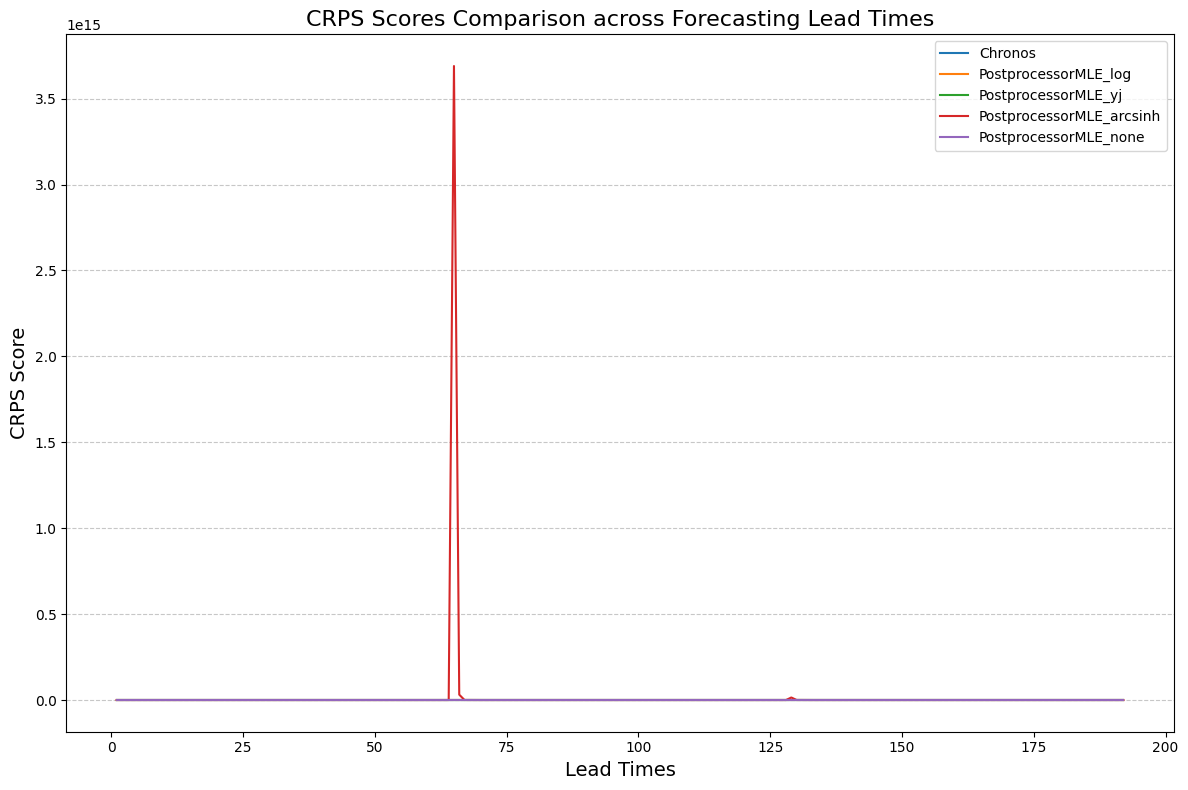

In [5]:
plot_crps_across_lead_times(results2[0], reference_predictions="Chronos")

In [7]:
get_crps_scores(results2[0])

,PostprocessorMLE_none,PostprocessorMLE_log,PostprocessorMLE_yj,Chronos,PostprocessorMLE_arcsinh
lead times,,,,,
1,855.396292,855.400399,857.230554,913.422442,1.153329e+03
2,1299.465683,1299.381699,1300.132946,1320.767846,3.091212e+03
3,1668.174075,1668.163513,1673.115044,1687.787707,8.145904e+03
4,1985.701406,1985.532406,1980.850508,2001.624001,1.484348e+04
5,2237.331553,2243.595913,2244.334761,2260.442329,2.556912e+04
...,...,...,...,...,...
189,4731.623265,4731.611182,4732.538835,4802.079494,1.465980e+04
190,4739.461419,4739.488363,4740.254478,4809.761421,1.274404e+04
191,4748.137708,4748.115703,4748.638204,4818.687021,1.323880e+04


In [9]:
# execution time in seconds
results2[1]

{'postprocessors': {'postprocessors_execution_time': {'PostprocessorMLE_log': 57.79,
   'PostprocessorMLE_yj': 50.5,
   'PostprocessorMLE_arcsinh': 34.96,
   'PostprocessorMLE_none': 49.33}}}

In [ ]:
# exchange rates

In [10]:
data, mapping, freq = read_exchange_rates_data(files_dir="../data/exchange_rates/")

2025-05-27 18:11:34,756 - INFO - preprocessor.py - Reading exchange rates data...
2025-05-27 18:11:34,757 - INFO - preprocessor.py - Reading file: ../data/exchange_rates/DEXCAUS.csv
2025-05-27 18:11:34,763 - INFO - preprocessor.py - Reading file: ../data/exchange_rates/DEXCHUS.csv
2025-05-27 18:11:34,767 - INFO - preprocessor.py - Reading file: ../data/exchange_rates/DEXJPUS.csv
2025-05-27 18:11:34,772 - INFO - preprocessor.py - Reading file: ../data/exchange_rates/DEXSIUS.csv
2025-05-27 18:11:34,778 - INFO - preprocessor.py - Reading file: ../data/exchange_rates/DEXSZUS.csv
2025-05-27 18:11:34,782 - INFO - preprocessor.py - Reading file: ../data/exchange_rates/DEXUSAL.csv
2025-05-27 18:11:34,788 - INFO - preprocessor.py - Reading file: ../data/exchange_rates/DEXUSNZ.csv
2025-05-27 18:11:34,792 - INFO - preprocessor.py - Reading file: ../data/exchange_rates/DEXUSUK.csv
2025-05-27 18:11:34,797 - INFO - preprocessor.py - Total rows after concatenation: 9214
2025-05-27 18:11:34,799 - INFO

In [15]:
# chronos zero shot results
pipeline = ForecastingPipeline(model=Chronos, 
                               model_kwargs={"pretrained_model_name_or_path": "amazon/chronos-bolt-tiny", "device_map": "mps", "lead_times": lead_times, "freq": freq}, 
                               postprocessors=[PostprocessorMLE, PostprocessorMLE, PostprocessorMLE, PostprocessorMLE],
                               postprocessor_kwargs=[{"transformer": "log", "epsilon": 1e-6, "name": "PostprocessorMLE_log"},
                                                     {"transformer": "yeo-johnson", "name": "PostprocessorMLE_yj"}, 
                                                     {"transformer": "arcsinh", "name": "PostprocessorMLE_arcsinh"},
                                                     {"transformer": None, "name": "PostprocessorMLE_none"}],
                               output_dir=Path("../results/tests/transformations-MLE/exchange-rates/chronos-zero-shot"))

results2 = pipeline.backtest(data=data,
                            test_start_date=pd.Timestamp("01-01-2023"),
                            rolling_window_eval=False,
                            train=False,
                            val_window_size=None,
                            train_window_size=None,
                            test_window_size=None,
                            calibration_based_on="train",
                            save_results=True)

2025-05-27 18:21:03,758 - INFO - chronos.py - Loading Chronos pipeline from model: amazon/chronos-bolt-tiny
2025-05-27 18:21:03,758 - INFO - chronos.py - Initializing Chronos pipeline with model: amazon/chronos-bolt-tiny
2025-05-27 18:21:05,070 - INFO - pipeline.py - Start E2E backtesting...
2025-05-27 18:21:05,071 - INFO - pipeline.py - Starting data split operation.
2025-05-27 18:21:05,073 - INFO - pipeline.py - Data split operation completed successfully.
2025-05-27 18:21:05,074 - INFO - pipeline.py - evaluate is set to true. Removing all item_ids which contain only nans in target column.
2025-05-27 18:21:05,076 - INFO - pipeline.py - Skipping model training because `train=False`.
2025-05-27 18:21:05,078 - INFO - pipeline.py - Starting prediction for test data from 2023-01-02 00:00:00 to 2025-04-25 00:00:00
2025-05-27 18:21:05,079 - INFO - pipeline.py - Running prediction using the model: Chronos
Predicting using Chronos:   0%|          | 0/1327 [00:00<?, ?it/s]/Users/louisskowronek

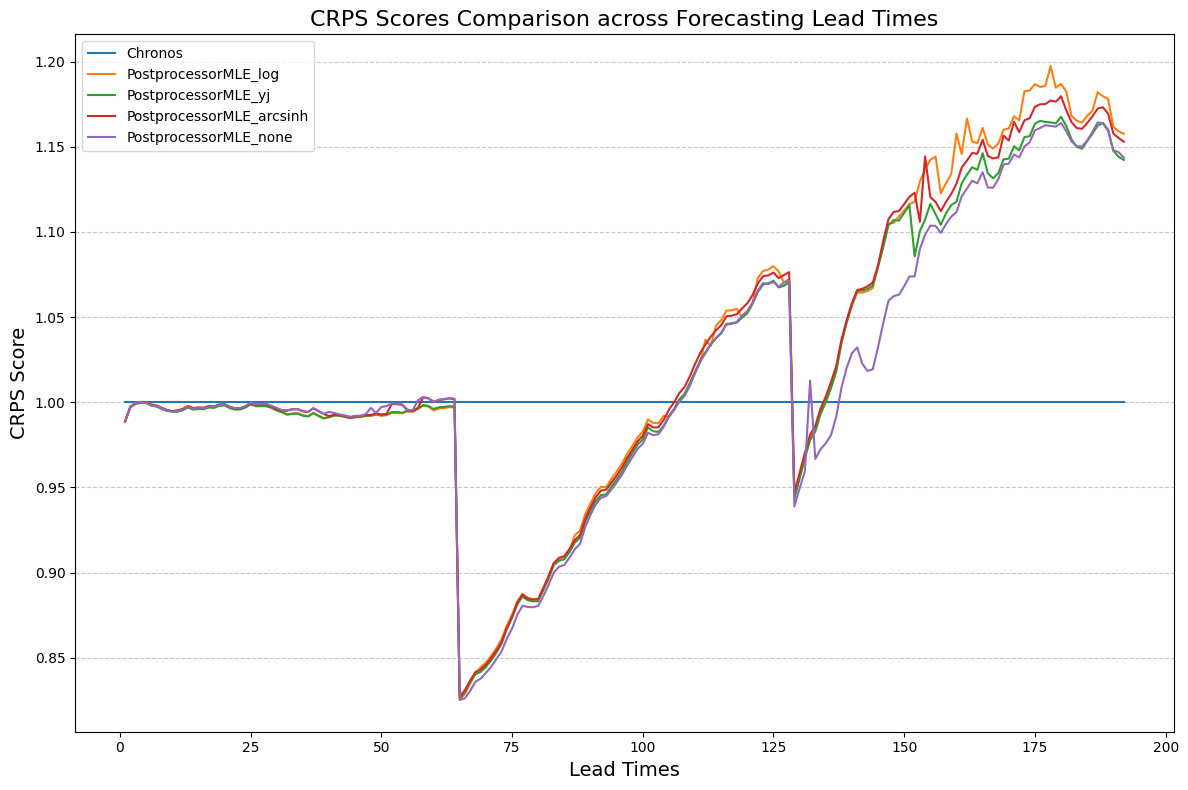

In [16]:
plot_crps_across_lead_times(results2[0], reference_predictions="Chronos")

In [17]:
get_crps_scores(results2[0])

,Chronos,PostprocessorMLE_none,PostprocessorMLE_yj,PostprocessorMLE_arcsinh,PostprocessorMLE_log
lead times,,,,,
1,0.002218,0.002193,0.002192,0.002193,0.002192
2,0.002879,0.002871,0.002870,0.002871,0.002871
3,0.003385,0.003383,0.003381,0.003383,0.003383
4,0.003817,0.003818,0.003816,0.003818,0.003818
5,0.004252,0.004251,0.004251,0.004253,0.004253
...,...,...,...,...,...
189,0.015412,0.017867,0.017880,0.018024,0.018155
190,0.015505,0.017800,0.017795,0.017951,0.018012
191,0.015540,0.017821,0.017778,0.017951,0.018013


In [18]:
# execution time in seconds
results2[1]

{'postprocessors': {'postprocessors_execution_time': {'PostprocessorMLE_log': 41.69,
   'PostprocessorMLE_yj': 23.28,
   'PostprocessorMLE_arcsinh': 26.01,
   'PostprocessorMLE_none': 25.21}}}

In [ ]:
# grosshandelspreise 

In [ ]:
data, mapping, freq = read_smard_data(file_paths=["../data/Gro_handelspreise_201501010000_202101010000_Stunde.csv",
                                                  "../data/Gro_handelspreise_202101010000_202504240000_Stunde.csv"],
                                      selected_time_series=None)

2025-05-26 17:56:40,948 - INFO - preprocessor.py - Reading SMARD data...
2025-05-26 17:56:40,949 - INFO - preprocessor.py - Reading file: ../data/Gro_handelspreise_201501010000_202101010000_Stunde.csv
2025-05-26 17:56:41,118 - INFO - preprocessor.py - Reading file: ../data/Gro_handelspreise_202101010000_202504240000_Stunde.csv
2025-05-26 17:56:41,233 - INFO - preprocessor.py - Total rows after concat: 90383
2025-05-26 17:56:41,265 - INFO - preprocessor.py - Reshaped DataFrame: 1536341 rows
2025-05-26 17:56:41,333 - INFO - preprocessor.py - Mapped 17 unique time series.
2025-05-26 17:56:41,334 - INFO - preprocessor.py - Final DataFrame memory usage: 35.16 MB


In [ ]:
data = data.loc[0:4].copy() # only consider a subset of data for testing

In [ ]:
# chronos zero shot results
pipeline = ForecastingPipeline(model=Chronos, 
                               model_kwargs={"pretrained_model_name_or_path": "amazon/chronos-bolt-tiny", "device_map": "mps", "lead_times": lead_times, "freq": freq}, 
                               postprocessors=[PostprocessorMLE, PostprocessorMLE, PostprocessorMLE, PostprocessorMLE],
                               postprocessor_kwargs=[{"transformer": "log", "epsilon": 1e6, "name": "PostprocessorMLE_log"},
                                                     {"transformer": "yeo-johnson", "name": "PostprocessorMLE_yj"}, 
                                                     {"transformer": "arcsinh", "name": "PostprocessorMLE_arcsinh"},
                                                     {"transformer": None, "name": "PostprocessorMLE_none"}],
                               output_dir=Path("../results/tests/transformations-MLE/wholesale-prices/chronos-zero-shot"))


results2 = pipeline.backtest(data=data,
                            test_start_date=pd.Timestamp("01-01-2023"),
                            rolling_window_eval=False,
                            train=False,
                            val_window_size=None,
                            train_window_size=None,
                            test_window_size=None,
                            calibration_based_on="train",
                            save_results=True)

2025-05-26 17:58:40,065 - INFO - chronos.py - Loading Chronos pipeline from model: amazon/chronos-bolt-tiny
2025-05-26 17:58:40,065 - INFO - chronos.py - Initializing Chronos pipeline with model: amazon/chronos-bolt-tiny
2025-05-26 17:58:40,743 - INFO - pipeline.py - Start E2E backtesting...
2025-05-26 17:58:40,745 - INFO - pipeline.py - Starting data split operation.
2025-05-26 17:58:40,752 - INFO - pipeline.py - Data split operation completed successfully.
2025-05-26 17:58:40,753 - INFO - pipeline.py - evaluate is set to true. Removing all item_ids which contain only nans in target column.
2025-05-26 17:58:40,756 - INFO - pipeline.py - Skipping model training because `train=False`.
2025-05-26 17:58:40,765 - INFO - pipeline.py - Starting prediction for test data from 2023-01-01 00:00:00 to 2025-04-23 23:00:00
2025-05-26 17:58:40,765 - INFO - pipeline.py - Running prediction using the model: Chronos
Predicting using Chronos:   0%|          | 0/6970 [00:00<?, ?it/s]/Users/louisskowronek

In [ ]:
get_crps_scores(results2[0])

Exception ignored in: <function ResourceTracker.__del__ at 0x108a49c60>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes


,PostprocessorQR_arcsinh,PostprocessorQR_none,PostprocessorQR_yj,Chronos
lead times,,,,
1,6.168064,6.178531,6.186770,6.327280
2,8.679513,8.705484,8.707504,8.776709
3,10.386582,10.416210,10.416233,10.475613
4,11.635864,11.664126,11.664011,11.729270
5,12.644762,12.672803,12.672261,12.736072
...,...,...,...,...
189,24.071957,24.165157,24.167987,24.924384
190,24.036490,24.129794,24.131932,24.858842
191,24.020975,24.109526,24.111359,24.827658


In [ ]:
results2[1]

{'postprocessors': {'postprocessors_execution_time': {'PostprocessorQR_yj': 421.77,
   'PostprocessorQR_arcsinh': 433.2,
   'PostprocessorQR_none': 533.55}}}